# Second-order vs. exact Markov chain knockoffs

The goal of this notebook is to reproduce Figure 1 of Sesia et al. (2018) discussion of Sesia et al. (2018),
in response to Figure 1 of Jewell and Witten (2018) discussion of Sesia et al. (2018).

Motivated from the tutorial GWAS tutorial from https://web.stanford.edu/group/candes/knockoffs/tutorials/gwas_tutorial.html#knockoff_diagnostics, we generate Markov chain covariates and consider two alternative constructions of knockoffs.

## Setup

In [1]:
library(SNPknock)
library(knockoff)
library(tidyverse)
library(gridExtra)
library(grid)
source("utils/utils.R")

# Simulation parameters
n <- 1000              # number of observations
p <- 1000              # number of covariates 
K <- 5                 # number of states for the Markov chain
write_directory <- 'local_experiments/'
load_experiments <- 'local_experiments/'
figure_directory <- 'figures/'
fdr <- 0.1

# Random seed
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



## Generate the covariates and the knockoffs

First, we generate the covariates and the exact knockoffs.

In [2]:
# Simulate discrete markov chain
markov_states <- simulate_discrete_markov_states(n, p, K)

# Generate exact knockoffs
knockoffs_dmc <- SNPknock.knockoffDMC(markov_states$covariates, 
                                      markov_states$prob_initial, 
                                      markov_states$transition_matrices, 
                                      display_progress = FALSE)

Now we compute the empirical covariance matrix of the data to construct Gaussian knockoffs.

In [3]:
Sigma.hat <- cov(markov_states$covariates)

Note the this empirical covariance matrix is almost singular, so Gaussian knockoffs will not have any power.

In [4]:
min(eigen(Sigma.hat)$values)

[1] 1.086734e-17

Therefore, we add a small amount of regularization.

In [5]:
# Regularized empirical covariance matrix
Sigma.hat <- (1-0.01)*Sigma.hat + 0.01*diag(rep(1,p))

In [6]:
# Generate second-order knockoffs
mu.hat <- colMeans(markov_states$covariates)
knockoffs_gaussian <- create.gaussian(markov_states$covariates, mu.hat, Sigma.hat)

## Knockoff diagnostics

In [7]:
# Calculate pairwise correlations for covariates and knockoffs
df_markov <- compute_covariate_knockoff_corr(markov_states$covariates, knockoffs_dmc)
df_markov$knockoff_type <- "Markov"

df_gaussian <- compute_covariate_knockoff_corr(markov_states$covariates, knockoffs_gaussian)
df_gaussian$knockoff_type <- "Gaussian"

df <- rbind(df_markov, df_gaussian)
df$knockoff_type <- factor(df$knockoff_type, levels = c("Markov", "Gaussian"), 
                           labels = c("Markov chain", "Gaussian approximation"))

In [8]:
# Compare the pairwise correlations under the correct model
p1 <- df %>% filter(knockoff_type == "Markov chain") %>% 
  ggplot(aes(x = covariate_corr, y = knockoff_corr)) + 
  geom_point(alpha = 0.25) + 
  facet_wrap(~knockoff_type) + 
  xlim(c(-0.1, 0.6)) +
  ylim(c(-0.1, 0.6)) +
  xlab('Pairwise covariate correlation') + 
  ylab('Pairwise knockoff correlation') + 
  geom_abline(slope = 1, intercept = 0, col = "red") +
  theme_bw() +
  theme(axis.text=element_text(size=11), strip.text.x = element_text(size = 11),
        axis.title=element_text(size=11),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())


# Compare the pairwise correlations under the misspecified model
p2 <- df %>% filter(knockoff_type == "Gaussian approximation") %>% 
  ggplot(aes(x = covariate_corr, y = knockoff_corr)) + 
  geom_point(alpha = 0.25) + 
  xlim(c(-0.1, 0.6)) +
  ylim(c(-0.1, 0.6)) +
  facet_wrap(~knockoff_type) + 
  xlab('Pairwise covariate correlation') + 
  ylab('Pairwise knockoff correlation') + 
  geom_abline(slope = 1, intercept = 0, col = "red") +
  theme_bw() +
  theme(axis.text=element_text(size=11), strip.text.x = element_text(size = 11),
        axis.title=element_text(size=11),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank())


png 
  2

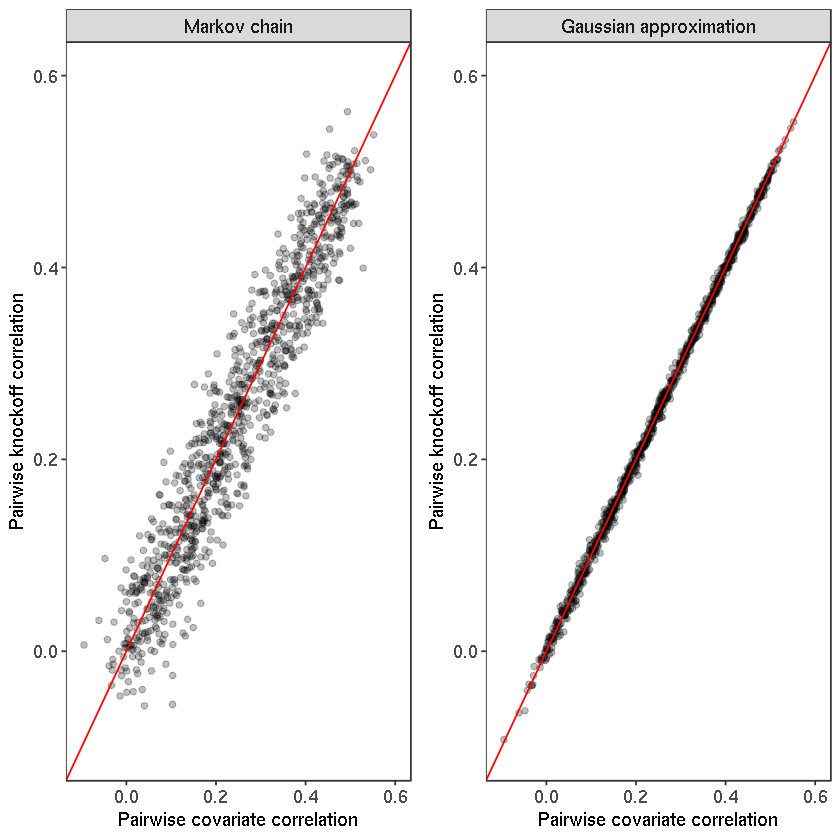

In [9]:
grid.arrange(p1, p2, ncol = 2)
pdf("figures/diagnostics.pdf",height = 3.5, width = 7.5)
grid.arrange(p1, p2, ncol = 2)
dev.off()

This suggests that in this case the Gaussian knockoffs are almost trivial copies of the original variables.

In [10]:
# Correlations between variables and knockoffs
self.corr.dmc = sapply(1:p, function(j) cor(markov_states$covariates[,j],knockoffs_dmc[,j]))
self.corr.gaussian = sapply(1:p, function(j) cor(markov_states$covariates[,j],knockoffs_gaussian[,j]))

In [11]:
self.corr <- tibble(Variable=1:p, DMC=self.corr.dmc, Gaussian=self.corr.gaussian)

Warning message:
“Using alpha for a discrete variable is not advised.”

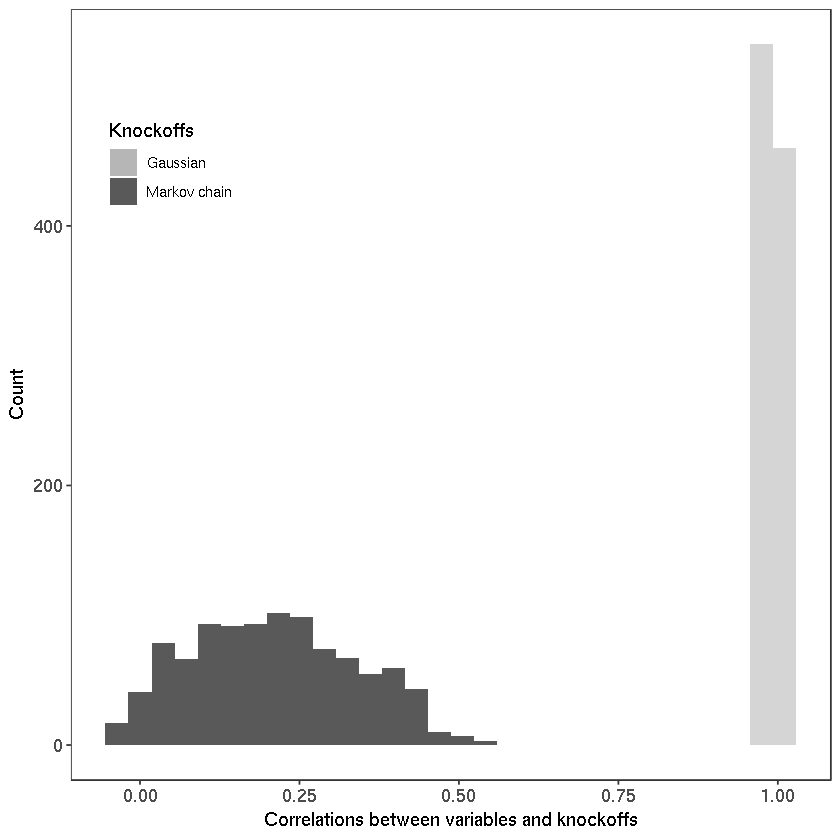

In [12]:
plt.self.corr <- self.corr %>% ggplot() + 
    geom_histogram(aes(x=DMC, alpha='Markov chain'), bins = 30) + 
    geom_histogram(aes(x=Gaussian, alpha='Gaussian',), bins = 30) +
    xlab('Correlations between variables and knockoffs') +
    ylab('Count') +
    scale_alpha_discrete(name="Knockoffs", range=c(0.25,1)) +
    theme_bw() +
    theme(axis.text=element_text(size=11), strip.text.x = element_text(size = 11),
          axis.title=element_text(size=11), legend.position=c(0.13,0.8),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank())
ggsave("figures/diagnostics_self.pdf", plt.self.corr, width = 6, height = 3)
plt.self.corr